In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *

In [3]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]


In [59]:
### Vista de datos
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow,RainToday_Yes,RainTomorrow_Yes
6047,427,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,False,False
6048,428,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,False,False
6049,429,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,0.0,False,False
6050,430,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,False,False
6051,431,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0.0,False,False


In [5]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [58]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

Date                  int64
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainfallTomorrow    float64
RainToday_Yes          bool
RainTomorrow_Yes       bool
dtype: object


In [57]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [7]:
#Se dummifican las columnas las columnas RainToday y RainTomorrow
#Se eliminan las columnas dummies complementarias para cada variable, a fin de evitar la colinealidad
df = pd.get_dummies(df, columns=['RainToday','RainTomorrow'])
df = df.drop(['RainToday_No','RainTomorrow_No'], axis=1)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow,RainToday_Yes,RainTomorrow_Yes
6047,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,False,False
6048,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,False,False
6049,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,0.0,False,False
6050,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,False,False
6051,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,2017-06-20,MountGambier,6.2,16.3,0.0,NaN,NaN,N,41.0,N,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,2.0,False,True
102516,2017-06-21,MountGambier,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,0.0,True,False
102517,2017-06-22,MountGambier,7.0,15.7,0.0,NaN,NaN,N,31.0,N,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,0.0,False,False
102518,2017-06-23,MountGambier,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,2.2,False,True


In [8]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26591.000000,27875.000000,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,11.263319,21.902078,2.050369,4.826499,6.891129,41.835471,15.130152,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,5.709936,6.693168,6.384560,3.707995,3.867622,14.186300,9.458606,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,7.400000,16.600000,0.000000,2.200000,3.800000,31.000000,9.000000,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,10.900000,21.000000,0.000000,4.000000,7.400000,39.000000,13.000000,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,15.200000,26.200000,1.000000,6.600000,10.000000,50.000000,20.000000,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,33.900000,46.800000,119.400000,86.200000,14.300000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


In [9]:
### Cantidad de valores faltantes.

df.isna().sum()

Date                   0
Location               0
MinTemp              570
MaxTemp              558
Rainfall             986
Evaporation         4353
Sunshine            6713
WindGustDir         1645
WindGustSpeed       1642
WindDir9am          1648
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Cloud9am            9367
Cloud3pm            9550
Temp9am              585
Temp3pm              576
RainfallTomorrow     985
RainToday_Yes          0
RainTomorrow_Yes       0
dtype: int64

In [65]:
analisis_nan(df)

NameError: name 'analisis_nan' is not defined

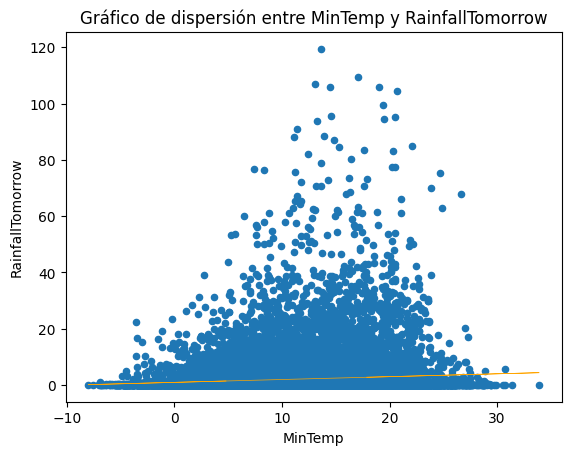

In [63]:
graf_dispersion(df, df.columns[2], 'RainfallTomorrow')

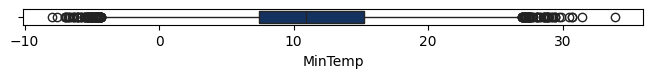

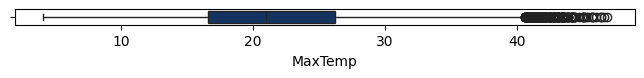

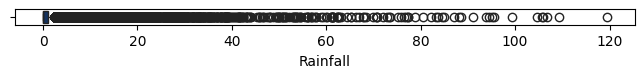

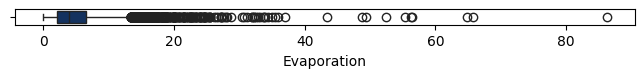

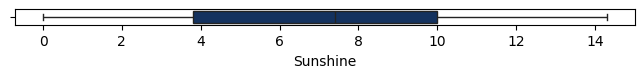

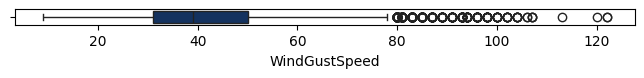

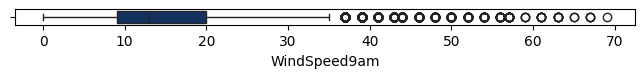

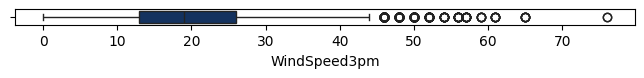

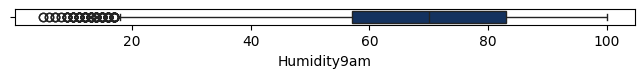

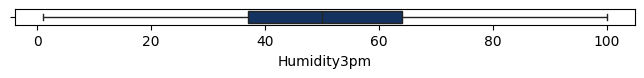

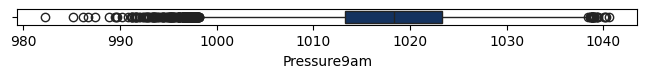

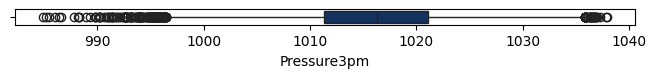

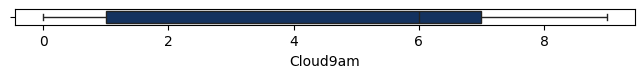

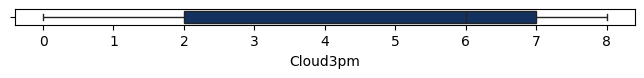

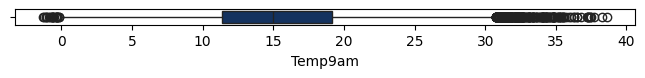

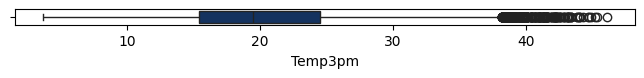

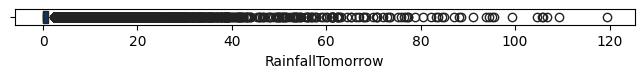

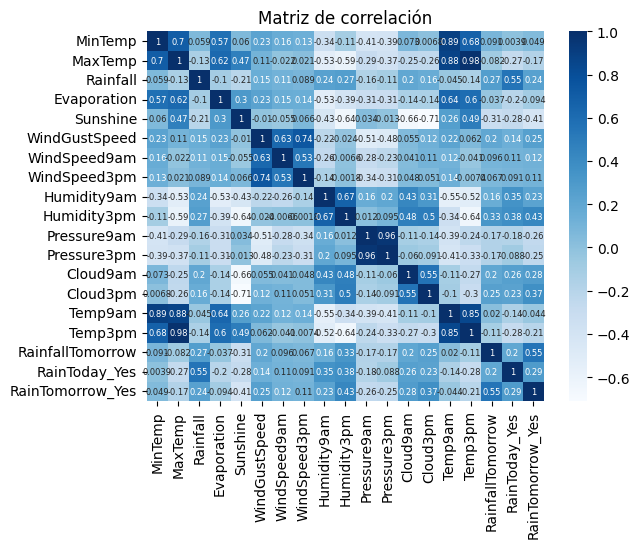

In [12]:
explorar(df)